# Première idée pour la modélisation 3D

In [1]:
import parcels
import cartopy
import numpy as np
import xarray as xr
from matplotlib import cm
import cartopy.crs as ccrs
from parcels import FieldSet
from datetime import timedelta
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec

### Clean the working directory before running the simulation

In [2]:
# import os
# import shutil
# 
# folder = r"C:\Users\ocean\PycharmProjects\Master MIX\StageM2\SEMES\Test"
# file_keep = "DailyRapidmCDR_LLC270_ACC_1995-01_0001ALK0.nc"   
# 
# # Delete all files and folders in the specified folder except the one to keep for final visualization
# for element in os.listdir(folder):
#     if element == file_keep:
#         continue  
# 
#     path_element = os.path.join(folder, element)
# 
#     if os.path.isfile(path_element) or os.path.islink(path_element):
#         os.remove(path_element)
# 
#     elif os.path.isdir(path_element):
#         shutil.rmtree(path_element)

# Integrate Rapid-mCDR model (OAE method) into 2D horizontal OceanParcels simulations with LL270 data

## 1) Define the Fieldset and variables required for continuous OAE simulation (alkalinity added daily in the initial cell of the ALK zero concentration field)

In [3]:
# Define the files to load depending on the time and depth
date = '1995-01'

# Define the data region and the time of the data
region = "ACC"

# Define the folder name to save the results
filename_save = f"DailyRapidmCDR_LLC270_ACC_{date}"

### Load the U, V, DIC and ALK monthly fields at the desired time and depth from the LLC270 dataset

In [4]:
# Definition of NetCDF files for U, V, W and ALK
path = "C:\\Users\\ocean\\PycharmProjects\\Master MIX\\StageM2\\SEMES\\Data" 
filenames = {
    "U": f"{path}\\UVEL_{date}_equal.nc",
    "V": f"{path}\\VVEL_{date}_equal.nc",
    "W": f"{path}\\WVEL_{date}.nc",
    "ALK": f"{path}\\ALK_{date}.nc"
}

# Definition of variables and dimensions
variables = {
    "U": "UVEL",
    "V": "VVEL",
    "W": "WVEL",
    "ALK": "ALK"
}

dimensions = {
    "U": {"depth": "Depth", "lat": "Latitude", "lon": "Longitude", "time": "Time"},
    "V": {"depth": "Depth", "lat": "Latitude", "lon": "Longitude", "time": "Time"},
    "W": {"depth": "Depth", "lat": "Latitude", "lon": "Longitude", "time": "Time"},
    "ALK": {"depth": "Depth", "lat": "Latitude", "lon": "Longitude", "time": "Time"}
}

# Create the FieldSet for velocities U, V and W as well as the ALK concentration fields on an Arakawa C grid
fieldset = FieldSet.from_netcdf(
    filenames,
    variables,
    dimensions,
    mesh="spherical",
    allow_time_extrapolation=True
)

# Define the interpolation method for the UV velocity fields
fieldset.UV.interp_method = "cgrid_velocity"

# Define the same dimensions as the DIC and ALK fields for the ALK0 and DIC0 concentration fields
depth_C = fieldset.ALK.data.shape[1]
lon_C = fieldset.ALK.data.shape[3]
lat_C = fieldset.ALK.data.shape[2]

# Create a field full of zeros for the particle simulation in ALK0 field
data_alk0 = np.zeros([depth_C, lat_C, lon_C])
field_alk0 = parcels.Field("ALK0", data_alk0, grid=fieldset.ALK.grid)
fieldset.add_field(field_alk0)


# Convert the fields to float64
for f in [fieldset.U, fieldset.V, fieldset.W, fieldset.ALK0, fieldset.ALK]:
    f.data = f.data.astype(np.float64)

# Enable data writing for final ALK
# fieldset.ALK0.to_write = True

# Define vertical diffusion coefficients K (in m^2/s)
K_diff_vertical = [1.0125125e-05, 8.9139901e-03, 2.7745981e-03, 6.6304987e-04, 2.4509168e-04,
7.1794559e-05, 1.4329043e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05,
1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05,
1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05,
1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05,
1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05,
1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05,
1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05,
1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05,
1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05]

# Constant vertical diffusion coefficient
# K_diff_vertical = 1.0000001e-05

fieldset.add_constant("K", K_diff_vertical)

# Define alkalinity forcing flux added continuously at the surface of the initial cell (in meq/(m^3 s))
fieldset.add_constant("alkalinity_forcing", 0.000012409)

# Calculate dz at each depth level and add it to the fieldset
dz = fieldset.ALK.depth[1:]-fieldset.ALK.depth[:-1]
dz = np.hstack((dz,dz[-1]))
fieldset.add_constant("dz", dz)


# # Create the matrix A for vertical diffusion calculation
# B = -2*np.identity(depth_C) + np.diag([1]*(depth_C-1),1) + np.diag([1]*(depth_C-1),-1)
# C = np.eye(50)*K_diff_vertical/dz**2
# fieldset.add_constant("A", B@C)

## 2) Define Kernels for the continuous OAE simulation with OceanParcels

In [5]:
def HorizontalAdvConcentration(particle, fieldset, time):
    """ 
    Kernel to implement horizontal advection due to particle movement in the horizontal OceanParcels simulation.
    This kernel calculates the change in the ALK0 concentration field due to horizontal advection of the particle.
    """
    
    ### Define the cell indexes of the particle in the grid and the depth level ###
    _ = fieldset.UV[particle] 
    
    xi, yi = particle.xi[fieldset.V.igrid], particle.yi[fieldset.U.igrid]
    
    # Correction of indexes if necessary
    if abs(particle.lon - fieldset.V.grid.lon[yi, xi + 1]) < abs(particle.lon - fieldset.V.grid.lon[yi, xi]):
        xi += 1
    if abs(particle.lat - fieldset.U.grid.lat[yi + 1, xi]) < abs(particle.lat - fieldset.U.grid.lat[yi, xi]):
        yi += 1
    if abs(particle.lon - fieldset.V.grid.lon[yi, xi - 1]) < abs(particle.lon - fieldset.V.grid.lon[yi, xi]):
        xi -= 1
    if abs(particle.lat - fieldset.U.grid.lat[yi - 1, xi]) < abs(particle.lat - fieldset.U.grid.lat[yi, xi]):
        yi -= 1
    
    # Get the zero ALK concentration fields for the OAE simulation
    ALK0 = fieldset.ALK0.data[0]  # In µM ALK
        
    ### Update the ALK0 concentration fields in the fieldset due to the particle movement along the water column ###
    # Move the ALK0 concentration column from the previous cells to the new cells
    if xi != particle.cell_x or yi != particle.cell_y:
        ALK0[:, yi, xi] += ALK0[:, particle.cell_y, particle.cell_x]
        ALK0[:, particle.cell_y, particle.cell_x] -= ALK0[:, particle.cell_y, particle.cell_x]
    
    # Save the particle's position for the next loop
    particle.cell_x = xi
    particle.cell_y = yi

    # Update the concentration field time to ensure temporal consistency
    fieldset.ALK0.grid.time[0] = time

In [6]:
def HorizontalAdvParticle(particle, fieldset, time):
    """
    Kernel to advect the particle using the 4th order Runge-Kutta method.
    This method is used to calculate the new position of the particle based on the velocity field U and V.
    """
    particle.lon = particle.lon_nextloop
    particle.lat = particle.lat_nextloop
    
    (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    # (u1, v1) = fieldset.UV[particle]
    lon1_adv, lat1_adv = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)
    
    (u2, v2) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat1_adv, lon1_adv]
    lon2_adv, lat2_adv = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)
    
    (u3, v3) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat2_adv, lon2_adv]
    lon3_adv, lat3_adv = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)
    
    (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3_adv, lon3_adv]
    
    particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
    particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt 
    
    particle.lon_nextloop = particle.lon + particle_dlon
    particle.lat_nextloop = particle.lat + particle_dlat 

In [7]:
def VerticalConcentration(particle, fieldset, time): 
    """
    Kernel to implement vertical advection and diffusion using an Eulerian scheme for the OAE method in the horizontal OceanParcels simulation.
    This kernel updates the ALK0 concentration field based on vertical transport processes.
    """
    import numpy as np
    
    dt = particle.dt
    _ = fieldset.UV[particle] 
    
    xi, yi = particle.xi[fieldset.V.igrid], particle.yi[fieldset.U.igrid]
    
    ### Correction of grid indexes if necessary ###
    if abs(particle.lon - fieldset.V.grid.lon[yi, xi + 1]) < abs(particle.lon - fieldset.V.grid.lon[yi, xi]):
        xi += 1
    if abs(particle.lat - fieldset.U.grid.lat[yi + 1, xi]) < abs(particle.lat - fieldset.U.grid.lat[yi, xi]):
        yi += 1
    if abs(particle.lon - fieldset.V.grid.lon[yi, xi - 1]) < abs(particle.lon - fieldset.V.grid.lon[yi, xi]):
        xi -= 1
    if abs(particle.lat - fieldset.U.grid.lat[yi - 1, xi]) < abs(particle.lat - fieldset.U.grid.lat[yi, xi]):
        yi -= 1

    # Retrieve the vertical ALK0 concentration column and vertical velocity column
    Nz      = fieldset.ALK0.data.shape[1]
    ALK_col = fieldset.ALK0.data[0, :, yi, xi]
    W_col   = fieldset.W.data[0, :, yi, xi]
     
    ALK_new = ALK_col.copy()

    ### Add alkalinity forcing to the surface cell during the first day ###
    if time < 86400:
        ALK_new[0] += fieldset.alkalinity_forcing * dt
        # Add the alkalinity forcing (0.000012409 meq/(m^3 s) converted to µM ALK) into the surface layer over the time step dt only for the initial cell
    
    # --------------------- Vertical Advection -----------------------
    for k in range(Nz - 2):

        # Compute interface thickness dz using vertical grid metrics
        dz = 0.5 * (fieldset.dz[k] + fieldset.dz[k+1])

        # Compute vertical velocity at the interface between levels k and k+1
        w = 0.5 * (W_col[k] + W_col[k+1])

        ### Compute the vertical advective flux ###
        if w < 0:
            # Downward flux: ALK transported from level k -> k+1
            flux = w * dt / dz * ALK_col[k]
        else:
            # Upward flux: ALK transported from level k+1 -> k
            flux = w * dt / dz * ALK_col[k+1]

        ### Apply the flux to the two adjacent levels ###
        ALK_new[k] += flux
        ALK_new[k + 1] -= flux   

    # Update the ALK0 3D field in the fieldset
    fieldset.ALK0.data[0, :, yi, xi] = ALK_new
    
    # Update the field time to ensure temporal consistency
    fieldset.ALK0.grid.time[0] = time

## 3) Run the OceanParcels simulation with the Rapid-mCDR model to simulate the continuous OAE method 

### Select the particle to track and the Kernel (Transport + OAE Method)

In [12]:
### Select the Particle to track and the Kernel (Transport + Conservation Methods) ###
position = (-2, -49)  # Initial position of the particle (longitude, latitude)
last_time = 31  # Number of days to run the simulation

In [13]:
# Definition of the particle and variables to track
class Particle(parcels.ScipyParticle):
    forcing_alk = parcels.Variable('f_alk', dtype=np.float64, initial=fieldset.alkalinity_forcing) # Additional alkalinity forcing (in meq/(m^3 s))
    endtime = parcels.Variable('endtime', dtype=np.int64, initial=last_time * 86400)  # End time of the particle tracking (in seconds)
    cell_x = parcels.Variable('cell_x', dtype=np.int32, initial=-1)  # Index of particle position at previous step in the grid (longitude)
    cell_y = parcels.Variable('cell_y', dtype=np.int32, initial=-1)  # Index of particle position at previous step in the grid (latitude)
    
lon_nextloop = Particle.add_variable('lon_nextloop', dtype=np.float32, to_write=True)  # Longitude of the particle at the next loop
lat_nextloop = Particle.add_variable('lat_nextloop', dtype=np.float32, to_write=True)  # Latitude of the particle at the next loop

# Creation of a particle set
pset = parcels.ParticleSet(fieldset=fieldset, pclass=Particle, lon=[position[0]], lat=[position[1]])

### Run the simulation during 1 month with 1 addition of ALK flux every day to the surface of the initial cell

In [14]:
# ---- FUNCTION TO SAVE ONLY THE FIELD ALK0 ----
def save_ALK0(fieldset, prefix):
    # Save the ALK0 field to a NetCDF file
    fieldset.ALK0.write(f"{prefix}")


# ---- SAVE THE INITIAL FIELDSET ----
# This captures the FieldSet state before any particle simulation starts
save_ALK0(fieldset, f"{filename_save}_initial")


# ---- FIRST EXECUTION ----
# Create the output file for particle trajectories
output_file = pset.ParticleFile(
    name=f"{filename_save}.zarr",
    outputdt=timedelta(days=1)
)

# Define kernels for the rapid-mCDR model
kernels = (
    pset.Kernel(VerticalConcentration)
    + pset.Kernel(HorizontalAdvConcentration)
    + pset.Kernel(HorizontalAdvParticle)
)

# Initial execution for the first particle (alkalinity addition at day 0 and tracking it for 'last_time' days)
pset.execute(
    kernels,
    dt=timedelta(days=1),
    runtime=timedelta(days=last_time),
    output_file=output_file
)


# ---- DAILY LOOP: INJECT A NEW PARTICLE EVERY DAY ----
for day in range(1, last_time):
    print(f"Day {day}: injecting a new particle at position {position} "
          f"and tracking it for {last_time - day} days")

    # Create a new ParticleSet with a single particle
    new_particle = parcels.ParticleSet(
        fieldset=fieldset,
        pclass=Particle,
        lon=[position[0]],
        lat=[position[1]]
    )

    # Assign the end time (in seconds) for this particle
    for p in new_particle:
        p.endtime = (last_time - day) * 86400

    # Add the new particle to the existing global ParticleSet
    pset.add(new_particle)

    # Determine how long this particle should be simulated (in days)
    remaining_runtime = timedelta(days=last_time - day)

    # Run the simulation for the current day
    pset.execute(
        kernels,
        dt=timedelta(days=1),
        runtime=remaining_runtime,
        output_file=output_file,
    )


# ---- SAVE THE FINAL FIELDSET ----
# This captures the FieldSet state after the very last model step
save_ALK0(fieldset, f"{filename_save}_final")

INFO: Output files are stored in DailyRapidmCDR_LLC270_ACC_1995-01.zarr.
  0%|          | 0/2678400.0 [00:00<?, ?it/s][1.0721376 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.       ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
  3%|▎         | 86400.0/2678400.0 [00:01<00:39, 65033.05it/s][1.0721376 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0. 

## 4) Load and visualize the results of the continuous OAE simulation

In [39]:
# Load the results
pset_traj = xr.open_zarr(f"{filename_save}.zarr")

### Plot the trajectory of the tracked particle and the concentration of ALK added to the initial cell over time

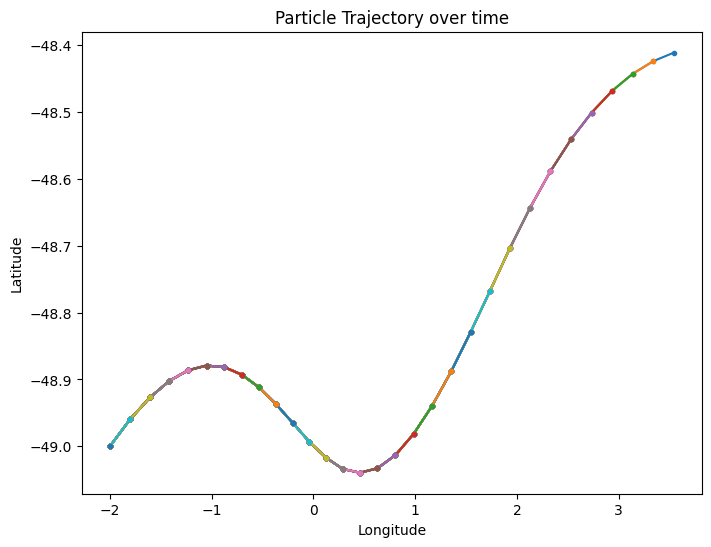

In [40]:
%matplotlib inline

plt.figure(figsize=(8, 6))
plt.plot(pset_traj["lon"].T, pset_traj["lat"].T, ".-")
plt.title("Particle Trajectory over time")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [41]:
print(f"Concentration of alk forcing particle added to initial cell over time (meq/(m^3s)) : \n {pset_traj['f_alk'].values[0]}")

Concentration of alk forcing particle added to initial cell over time (meq/(m^3s)) : 
 [1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05
 1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05
 1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05
 1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05
 1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05 1.2409e-05
 1.2409e-05]


### Plot the concentration fields of ALK in 2D and 3D at the end of the continuous OAE simulation with addition of ALK flux every day at the initial cell

In [42]:
### PARAMETERS ###
var_name = "ALK0"                    # Variable to plot
depth_target = 1                     # Index of the depth level to plot (in meters)
extent = [-3, 5, -50, -48]           # Spatial extent for the plot [lon_min, lon_max, lat_min, lat_max]

# Depth levels from the model
depth_levels = np.array([
     0., 10., 20., 30., 40., 50.,
     60., 70., 80.01, 90.04, 100.15, 110.47,
     121.27, 133.03, 146.45, 162.49, 182.31, 207.16,
     238.26, 276.68, 323.18, 378.18, 441.68, 513.26,
     592.16, 677.31, 767.49, 861.45, 958.03, 1056.28,
     1155.53, 1255.54, 1356.87, 1461.43, 1572.76, 1695.59,
     1834.68, 1993.62, 2174.45, 2378., 2604.5, 2854.,
     3126.5, 3422., 3740.5, 4082., 4446.5, 4834.,
     5244.5, 5678.
], dtype=np.float32)

### LOAD initial and final concentrations for the variable ###
ds_initial = xr.open_dataset(f"{filename_save}_initial{var_name}.nc")
ds_final   = xr.open_dataset(f"{filename_save}_final{var_name}.nc")

field_initial = ds_initial[var_name].values[0]   # (nz, ny, nx)
field_final   = ds_final[var_name].values[0]

lon = ds_final["nav_lon"].values
lat = ds_final["nav_lat"].values

### SELECT DEPTH INDEX ###
print(f"Selected depth = {depth_levels[depth_target]}m")

# 2D slices at selected depth
f0_initial_2D = field_initial[depth_target]
f0_final_2D   = field_final[depth_target]

### SPATIAL CROP ###
lon_min, lon_max, lat_min, lat_max = extent

mask_lon = (lon >= lon_min) & (lon <= lon_max)
mask_lat = (lat >= lat_min) & (lat <= lat_max)
mask_extent = mask_lon & mask_lat

i_idx = np.where(mask_extent.any(axis=1))[0]
j_idx = np.where(mask_extent.any(axis=0))[0]

Selected depth = 10.0m


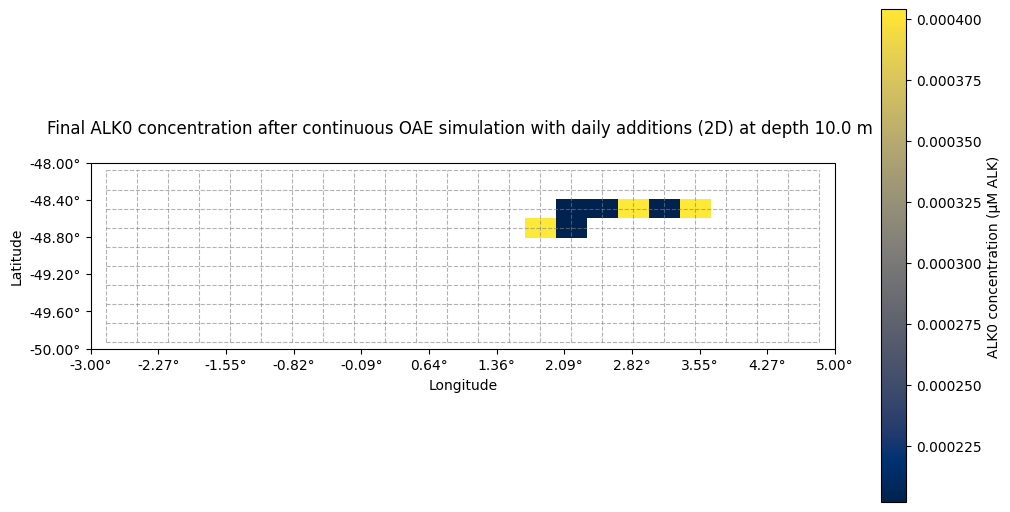

In [43]:
### 2D PLOT AT SELECTED DEPTH ###
%matplotlib inline

# Cropped 2D fields
f0_initial_crop_2D = f0_initial_2D[i_idx][:, j_idx]
f0_final_crop_2D   = f0_final_2D[i_idx][:, j_idx]

lon_crop = lon[i_idx][:, j_idx]
lat_crop = lat[i_idx][:, j_idx]

# Compute 2D mask: only show cells that changed
f0_masked_2D = np.copy(f0_final_crop_2D)
f0_masked_2D[f0_masked_2D == f0_initial_crop_2D] = np.nan

# ---- PLOT ----
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="floralwhite", edgecolor="black")

vmin = np.nanmin(f0_masked_2D)
vmax = np.nanmax(f0_masked_2D)

pcm = ax.pcolormesh(
    lon_crop, lat_crop, f0_masked_2D,
    cmap="cividis", vmin=vmin, vmax=vmax,
    transform=ccrs.PlateCarree()
)

# ---- ADD GRIDLINES FROM THE MESH ----
# Horizontal lines (constant latitude)
for j in range(lon_crop.shape[0]):
    ax.plot(
        lon_crop[j, :], lat_crop[j, :],
        color="gray", linewidth=0.8, linestyle="--",
        transform=ccrs.PlateCarree(), alpha=0.6
    )
# Vertical lines (constant longitude)
for i in range(lon_crop.shape[1]):
    ax.plot(
        lon_crop[:, i], lat_crop[:, i],
        color="gray", linewidth=0.8, linestyle="--",
        transform=ccrs.PlateCarree(), alpha=0.6
    )

# ---- AXIS TICKS with REAL LAT/LON ----
# Choose tick spacing
sample_x = np.linspace(extent[0], extent[1], 12)   
sample_y = np.linspace(extent[2], extent[3], 6)

ax.set_xticks(sample_x, crs=ccrs.PlateCarree())
ax.set_yticks(sample_y, crs=ccrs.PlateCarree())

ax.set_xticklabels([f"{x:.2f}°" for x in sample_x])
ax.set_yticklabels([f"{y:.2f}°" for y in sample_y])

# ---- COLORBAR & LABELS ----
cbar = plt.colorbar(pcm, ax=ax, shrink=0.8)
cbar.set_label(f"{var_name} concentration (µM ALK)")

ax.set_title(f'Final {var_name} concentration after continuous OAE simulation with daily additions (2D) at depth {depth_levels[depth_target]:.1f} m \n')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [44]:
### 3D PLOT OF THE FULL DEPTH RANGE ###
%matplotlib tk

# Cropped 3D fields
field_initial_crop3D = field_initial[:, i_idx][:, :, j_idx]
field_final_crop3D   = field_final[:, i_idx][:, :, j_idx]

# ---- MASK COMPUTATION ----
field_mask3D = np.copy(field_final_crop3D)
field_mask3D[field_mask3D == field_initial_crop3D] = np.nan

mask3D = ~np.isnan(field_mask3D)
nz, ny, nx = mask3D.shape

# Prepare colors
vmin_3D = np.nanmin(field_mask3D)
vmax_3D = np.nanmax(field_mask3D)

cmap = plt.get_cmap("cividis")
norm = plt.Normalize(vmin=vmin_3D, vmax=vmax_3D)

facecolors = np.zeros(field_mask3D.shape + (4,), dtype=np.float32)
facecolors[mask3D] = cmap(norm(field_mask3D[mask3D]))

# Swapping axes for voxel plotting
mask_swapped = np.transpose(mask3D, (2, 1, 0))
facecolors_swapped = np.transpose(facecolors, (2, 1, 0, 3))

# ---- PLOT ----
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

ax.voxels(mask_swapped, facecolors=facecolors_swapped, edgecolor='k', alpha=0.9)

nx_new, ny_new, nz_new = mask_swapped.shape

# Axis ticks converted to real coordinates
x_ticks_idx = np.arange(0, nx_new, 2, dtype=int)
y_ticks_idx = np.arange(0, ny_new, 1, dtype=int)
z_ticks_idx = np.arange(0, min(6, nz_new), dtype=int)

ax.set_xticks(x_ticks_idx)
ax.set_yticks(y_ticks_idx)
ax.set_zticks(z_ticks_idx)

ax.set_xticklabels([f"{lon_crop[0, i]:.2f}" for i in x_ticks_idx])
ax.set_yticklabels([f"{lat_crop[j, 0]:.2f}" for j in y_ticks_idx])
ax.set_zticklabels([f"{i:.0f}" for i in z_ticks_idx])

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_title(f'Final {var_name} concentration after continuous OAE simulation with daily additions (3D)')

# Colorbar
mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(field_mask3D[mask3D])
plt.colorbar(mappable, ax=ax, shrink=0.5, label=f'{var_name} concentration (µM ALK)')

plt.show()

In [48]:
print(f"At the end of the simulation, the total ALK0 field is {np.nansum(field_mask3D)} µM ALK. This value must match the total ALK flux added each day to the initial cell, after conversion to µM ALK: {np.nansum(pset_traj['f_alk'].values[:, 0] * timedelta(days=1).total_seconds())}")

print(f"Difference between the sum of alkalinity adding every day and mass conservation at the end of simulation: {np.abs(np.nansum(field_mask3D) - np.nansum(pset_traj['f_alk'].values[:, 0] * timedelta(days=1).total_seconds()) )}")

At the end of the simulation, the total ALK0 field is 33.2362656 µM ALK. This value must match the total ALK flux added each day to the initial cell, after conversion to µM ALK: 33.2362656
Difference between the sum of alkalinity adding every day and mass conservation at the end of simulation: 0.0
